In [47]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important}</style>"))

### Notes, emphasized info from competition's web site

__YOU CAN JUST SKIP IT__

#### Отделить 2017 год 
#### Разбить travel permit по декларациям из других таблиц
#### Тогда можно проверять amounts
__Staff members cannot be identified in the data. Instead, for all steps, the role of the person executed the step is recorded. The resource recorded in the data is either the SYSTEM, a STAFF MEMBER or UNKNOWN, or, on occasion, the data is MISSING.__

__ALL docs follow a SIMILAR process flow.__

__*After submission by the employee, the request is sent for approval to the travel administration. If approved, the request is then forwarded to the budget owner and after that to the supervisor. The process finished with either the trip taking place or a payment being requested and payed.*__

* employee
* travel administration
* budget owner
* supervisor (optionally for internesional)
* director (optionally)

__*To get the costs for a travel reimbursed, a claim REQUESTS FOR PAYMENT is filed.*__ 

#### More detailed questions

- How many travel declarations are booked on projects?
- How many corrections have been made for declarations?
- Are there any double payments?
- Are there declarations that were not preceded properly by an approved travel permit? Or are there even declarations for which no permit exists?
- How many travel declarations are submitted by the traveler and how many by a mandated person?
- How many travel declarations are first rejected because they are submitted more than 2 months after the end of a trip and are then re-submitted?
- Is this different between departments?
- How many travel declarations are not approved by budget holders in time (7 days) and are then automatically rerouted to supervisors?
- Next to travel declarations, there are also requests for payments. These are specific for non-TU/e employees.
- Are there any TU/e employees that submitted a request for payment instead of a travel declaration?

__*not all questions can be answered on this dataset and we encourage the participants to come up with new and interesting insights.*__

#### The following questions are of interest:

- What is the throughput of a travel declaration from submission (or closing) to paying?
- Is there are difference in throughput between national and international trips?
- Are there differences between clusters of declarations, for example between cost centers/departments/projects etc.?
- What is the throughput in each of the process steps, i.e. the submission, judgement by various responsible roles and payment?
- Where are the bottlenecks in the process of a travel declaration?
- Where are the bottlenecks in the process of a travel permit (note that there can be mulitple requests for payment and declarations per permit)?
- How many travel declarations get rejected in the various processing steps and how many are never approved?

#### the focus is on
1. __originality of the results__
2. __validity of the claims__
3. __depth of the analysis of specific issues identified__

analyze specific aspect in detail

Here, one can choose for example to focus on specific models, such as control-flow models, social network models, performance models, predictive models, etc.

#### Non-student advances

1. __completeness of analysis__
2. __usefulness for the purpose of a real-life process mining setting.__

### This cell contains primary code. It will be used as one project, created specifically for challendge.

__If you want to change something or add new features - it's highly recommended to get familiar with this piece 
before you try.__

__I am open to questions.__

In [2]:
from pm4py.objects.log.importer.xes import importer as xes_importer
import pm4py.objects.conversion.log
from pm4py.objects.conversion.log import converter
from pm4py.objects.log.util import dataframe_utils
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('darkgrid'); sns.set_palette('seismic_r')
import matplotlib.pyplot as plt
import sys
import re

data_path = Path('../data/')
DD = 'domestic declarations'
ID = 'international declarations'
PT = 'prepaid travel costs'
RP = 'request for payment'
TP = 'travel permitions'

datasets = [DD, ID, PT, RP, TP]
datasets = [data_path / x for x in datasets]  


'''further funcs supposed to be class methods in future versions'''


def atoi_like(s, option='first'):
    """parser of ANY numeric data from str ones; output is in str format"""
    
    try:
        num_str = s.strip()
        num_str = re.findall(r"[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", num_str)
        if option == 'all': return num_str 
        else: return num_str[0]  # functional can be upgraded later
    except (IndexError, TypeError, ValueError, AttributeError): return s
    
    
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)
    
    
def readme_logs():
    """the same as xes_event_logs for readme files; saves in var desc"""
    try:
        data = globals()['desc']
    except KeyError:
        data = dict()
        for _dir in datasets:
            for dataset in _dir.iterdir():
                readme = open(str(dataset))
                data[str(_dir.relative_to(data_path))] = readme.read() if\
                    str(dataset).endswith('txt') else data.get(str(_dir.relative_to(data_path)));
                readme.close()

    return data
    
    
def xes_event_logs():  # !TODO  modify inprogress widget desc
    """pulls .xes files from dirs and saves to pm4py Event_log; saves in var logs"""
    
    try:
        data = globals()['logs']
    except KeyError:
        data = dict()
        for _dir in datasets:
            for dataset in _dir.iterdir():
                data[str(_dir.relative_to(data_path))] = xes_importer.apply(str(dataset)) if\
                    str(dataset).endswith('xes') else data.get(str(_dir.relative_to(data_path)));
    
    return data


def xes2dataframe(xes_file, configuration='convenient', sortby=False, gmt_time=True, tz=False):  # needs to be simpler one
    """represents .xes file as pandas dataframe with opportunity of exporting options choice;
    implemented for performance achievment either;  
    it's not recommended to use 'sortby' option with 'default' mode;
    does job from scratch"""
    
    variant = converter.Variants.TO_DATA_FRAME
    params = {variant.value.Parameters.DEEP_COPY: True}  # can be reconsidered
    print(f'converting event log {xes_file} to dataframe')
    try:
        xes_file = globals()['logs'][xes_file]
    except KeyError:
        print('accesing ".xes" data failed. xes_event_logs must be invoked')
        return
    
    dataframe = converter.apply(xes_file,\
                variant=variant, parameters=params)  # just conversion
    
    '''tuning section start'''
    if configuration == 'convenient':
        print('applying cosmetic changes')
        for symb in [':', ' ']:
            dataframe.rename(columns={name: name.replace(symb, '_') for\
                                      name in dataframe.columns}, inplace=True) # just formatting
        
        dataframe = dataframe_utils.convert_timestamp_columns_in_df(dataframe) if gmt_time else dataframe # gmt time
        dataframe.time_timestamp = dataframe.time_timestamp.apply(lambda x: x.tz_localize(None))\
                                    if not tz else dataframe.time_timestamp  # removing timezone
        for col in dataframe.columns[np.where(dataframe.columns == 'id',False,True)]:  # taking all but id 
            dataframe[col] = dataframe[col].apply(lambda x: atoi_like(x))  # removing extraneous data before declaration number
        '''rebuilding id'''
        id_cat = pd.DataFrame(dataframe.id.apply(lambda x: f'{x.split()[0]}_class_{x.split("_")[-1]}'))\
                                    .rename(columns={'id': 'id_cat'})
        dataframe.id = dataframe.id.apply(lambda x: atoi_like(x))
        dataframe = pd.merge(id_cat, dataframe, on=dataframe.index,  # always use on with index, otherwise you get dups
                       how='right').drop('key_0', axis=1)  # made it with id categories 
        
        try:  # FIXME it's not normal behaviour; 5th fails
            num_fields = dataframe.select_dtypes(include=['int', 'float'])  # casting numeric fields to uint32 for performance objective
            num_fields = num_fields.astype('uint32')
            dataframe[num_fields.columns] = num_fields
        except ValueError:
            pass
        
        obj_fields = dataframe.select_dtypes(include=['object']).copy()
        for col in obj_fields.columns:  # categorizing object fields for performance objective
            num_unique_values, num_total_values = len(obj_fields[col].unique()), len(obj_fields[col])
            obj_fields.loc[:,col] = obj_fields[col].astype('category') 
        dataframe[obj_fields.columns] = obj_fields
        
        if not sortby:
            pass
        else:
            dataframe = dataframe.sort_values(sortby)  # sorting by column parameter
        '''tuning section end'''
    
    elif configuration == 'default':
        print('proceeding with standard pm4py event <-> df conversion')
        
    print('MEM consumption:\t', mem_usage(dataframe))
    return dataframe

    
def all_dataframes(configuration='convenient'):  # inprogress widget
    """gets all dataframes at once and saves in var all_dfs"""
        
    try:  # want it to be fancier
        df_dict = globals()['all_dfs']
        xes_files = globals()['logs']
        for _ in tqdm(iter(xes_files.keys()),\
                      desc='TRAVERSING LOGS IN DICT OF DATAFRAMES'):
                print('current log:\t', _)
                df_dict[_] = xes2dataframe(_, configuration=configuration) if df_dict[_] is None else df_dict[_];
                
    except:
        df_dict = dict()
        xes_event_logs()
        all_dataframes()
        
    return df_dict

### Run every cell in this section to get to work

In [3]:
logs = xes_event_logs()

In [4]:
desc = readme_logs()
print('------------------------------')
print('description')  # readme inside data dir
print('------------------------------')
print()
print(desc[list(logs.keys())[4]])  # any number from 0 to 4
print('------------------------------')
print('logs inwards')  # .xes log slice
print('------------------------------')
logs[list(logs.keys())[1]][0][0]  # i. e. of usage

------------------------------
description
------------------------------

The tenth International Business Process Intelligence Challenge is again co-located with ICPM. This challenge provides participants with a real-life event log, and challenges them to analyze these data using whatever techniques available, focusing on one or more of the process owner’s questions or proving other unique insights into the process(es) captured in the event log.

In many organizations, staff members travel for work. They travel to customers, to conferences or to project meetings and these travels are sometimes expensive. As an employee of an organization, you do not have to pay for your own travel expenses, but the company takes care of them.

For this year’s Business Process Intelligence Challenge, we collected data from the reimbursement process at TU/e. The files contain data from 2017 (only two departments) and 2018 the full TU/e.

The data is split into travel permits and several request types, 

{'id': 'rv_travel permit 76455_6', 'org:resource': 'STAFF MEMBER', 'concept:name': 'Start trip', 'time:timestamp': datetime.datetime(2016, 10, 5, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'org:role': 'EMPLOYEE'}

__kostylb INITIATED__

In [5]:
# kostylb unfot  'to_drop'
%run df_4_drop.py

In [6]:
names = [DD, ID, PT, RP, TP]
all_dfs = {name: None for name in names}
all_dfs[TP] = xes2dataframe(tuple(logs.keys())[4]).drop(to_drop, axis=1)
assembled_fields = ['case_RfpNumber', 'case_Rfp_id', 'case_dec_id']
csv_file = pd.read_csv(datasets[-1] / 'compact_PermitLog.csv').rename(columns={'case:RfpNumber': 'case_RfpNumber',\
                                'case:Rfp_id': 'case_Rfp_id', 'case:dec_id': 'case_dec_id'})[assembled_fields]
all_dfs[TP][assembled_fields] = csv_file
all_dfs[TP].drop('case_dec_id_0', axis=1, inplace=True)
all_dfs[TP].case_dec_id = all_dfs[TP].case_dec_id.apply(lambda x: atoi_like(x)) 

converting event log travel permitions to dataframe
applying cosmetic changes
MEM consumption:	 38.98 MB


__kostylb TERMINATED__

In [7]:
all_dfs = all_dataframes()  # TODO! from tqdm widget to inprogress

TRAVERSING LOGS IN DICT OF DATAFRAMES: 0it [00:00, ?it/s]

current log:	 domestic declarations
converting event log domestic declarations to dataframe
applying cosmetic changes


TRAVERSING LOGS IN DICT OF DATAFRAMES: 1it [00:05,  5.03s/it]

MEM consumption:	 8.71 MB
current log:	 international declarations
converting event log international declarations to dataframe
applying cosmetic changes


TRAVERSING LOGS IN DICT OF DATAFRAMES: 2it [00:15,  6.56s/it]

MEM consumption:	 14.64 MB
current log:	 prepaid travel costs
converting event log prepaid travel costs to dataframe
applying cosmetic changes


TRAVERSING LOGS IN DICT OF DATAFRAMES: 3it [00:17,  5.30s/it]

MEM consumption:	 3.40 MB
current log:	 request for payment
converting event log request for payment to dataframe
applying cosmetic changes


TRAVERSING LOGS IN DICT OF DATAFRAMES: 5it [00:21,  4.29s/it]

MEM consumption:	 6.74 MB
current log:	 travel permitions


### Dataframes in order 

In [8]:
# names = [DD, ID, PT, RP, TP]
display(DD, all_dfs[DD].head(1), all_dfs[DD].shape)
display(ID, all_dfs[ID].head(1), all_dfs[ID].shape)
display(PT, all_dfs[PT].head(1), all_dfs[PT].shape)
display(RP, all_dfs[RP].head(1), all_dfs[RP].shape)
display(TP, all_dfs[TP].head(1), all_dfs[TP].shape)

'domestic declarations'

,id_cat,id,org_resource,concept_name,time_timestamp,org_role,case_id,case_concept_name,case_BudgetNumber,case_DeclarationNumber,case_Amount
0,st_step_class_0,86794,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 08:49:50,EMPLOYEE,86791,86791,86566,86792,26


(56437, 11)

'international declarations'

,id_cat,id,org_resource,concept_name,time_timestamp,org_role,case_Permit_travel_permit_number,case_DeclarationNumber,case_Amount,case_RequestedAmount,...,case_concept_name,case_Permit_OrganizationalEntity,case_travel_permit_number,case_Permit_RequestedBudget,case_id,case_Permit_ID,case_Permit_id,case_BudgetNumber,case_Permit_ActivityNumber,case_AdjustedAmount
0,rv_travel_class_6,76455,STAFF MEMBER,Start trip,2016-10-04 22:00:00,EMPLOYEE,76456,76458,39,39,...,76457,65458,76456,41,76457,76455,76455,144133,46005,39


(72151, 24)

'prepaid travel costs'

,id_cat,id,org_resource,concept_name,time_timestamp,org_role,case_Rfp_id,case_Permit_travel_permit_number,case_Task,case_OrganizationalEntity,...,case_Permit_BudgetNumber,case_Permit_ProjectNumber,case_Project,case_concept_name,case_Permit_OrganizationalEntity,case_Permit_RequestedBudget,case_Cost_Type,case_Permit_id,case_Permit_ActivityNumber,case_RfpNumber
0,st_step_class_0,73555,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2017-01-09 13:48:43,EMPLOYEE,73550,UNKNOWN,71977,65463,...,6198,UNKNOWN,503,73550,65455,1979,0,73549,UNKNOWN,73551


(18246, 23)

'request for payment'

,id_cat,id,org_resource,concept_name,time_timestamp,org_role,case_Rfp_id,case_Project,case_Task,case_concept_name,case_OrganizationalEntity,case_Cost_Type,case_RequestedAmount,case_Activity,case_RfpNumber
0,st_step_class_0,148220,STAFF MEMBER,Request For Payment SUBMITTED by EMPLOYEE,2017-01-09 08:17:18,EMPLOYEE,148214,148216,UNKNOWN,148214,65463,0,34,UNKNOWN,148215


(36796, 15)

'travel permitions'

,id_cat,id,org_resource,concept_name,time_timestamp,org_role,case_OrganizationalEntity,case_ProjectNumber,case_TaskNumber,case_ActivityNumber,...,case_Overspent,case_travel_permit_number,case_DeclarationNumber_0,case_id,case_RequestedBudget,case_BudgetNumber,case_OverspentAmount,case_RfpNumber,case_Rfp_id,case_dec_id
0,rv_travel_class_6,76455,STAFF MEMBER,Start trip,2016-10-04 22:00:00,EMPLOYEE,65458,UNKNOWN,UNKNOWN,46005,...,False,76456,76458,76455,41.613445,922,0.0,NaN,NaN,76457


(86581, 23)

### Saving current csv files

In [9]:
def write_csv_along_xes():
    for dataset in datasets:
        name = str(dataset.relative_to(data_path))
        all_dfs[name].to_csv(f'{dataset}/{name}.csv')
    
# write_csv_along_xes()

### Dropdown widget:  tables, fields, plots, e. t. c. 
__cell is in develop; code will be hidden though__

__if you know how to do it fancier, you're WELCOME__

__function templates are in demand__

In [9]:
from ipywidgets import Dropdown, Output, HBox, VBox, Tab
from IPython.display import display, Markdown


default = 'CLOSED'
options = ['CLOSED', 'domestic declarations', 'international declarations',\
            'prepaid travel costs', 'request for payment', 'travel permitions']
all_dfs = globals()['all_dfs']  # don't know if it works when importing py script

dropdown_ta = Dropdown(options=options, value=default,
                   description='Table')
dropdown_ke = Dropdown(options=options, value=default,
                   description='Key table')
dropdown_am = Dropdown(options=options, value=default,
                   description='Unique vals')
dropdown_in = Dropdown(options=options, value=default,
                   description='INFO')

output_ta = Output()
output_ke = Output()
output_am = Output()
output_in = Output()


def main_eventhandler(table, key_table, amount, info):
    output_ta.clear_output()
    output_ke.clear_output()
    output_am.clear_output()  # amount should be as table too
    output_in.clear_output()
    
    if table == default:
        view = Markdown("<font color='#DA77D3' size=4><center>'Nothing to display for tables'</center></font>")
        with output_ta:
            display(view)
    else:
        view = all_dfs[table].sample(frac=1).head(8)  # 8 random rows
        with output_ta:
            display(view.style.applymap(lambda x: 'color: orange'))
    if key_table == default:
        view = Markdown("<font color='#DA77D3' size=4><center>'Nothing to display for key tables'</center></font>")
        with output_ke:
            display(view)
    else:
        view = pd.concat([all_dfs[key_table]], keys=all_dfs[key_table].id_cat).\
                        sample(frac=1).head(8)  # 12 random rows for grouped on id cat
        with output_ke:
            display(view.style.applymap(lambda x: 'color: orange'))
    if amount == default:
        amount = Markdown("<font color='#DA77D3' size=4><center>'Nothing to display for unique fields'</center></font>")
        with output_am:
            display(amount)
    else:
        with output_am:
            display(Markdown(f'{amount}.md'))
    if info == default:
        info = Markdown("<font color='#DA77D3' size=4><center>'Nothing to display for info'</center></font>")
        with output_in:
            display(info)
    else:  # FIXME
        info1 = all_dfs[table].describe()
        info2 = all_dfs[table].info()
        with output_in:
            display(info1)
            display(info2)

            
def tables_eventhandler(option):
    main_eventhandler(option.new, dropdown_ke.value, dropdown_am.value, dropdown_in.value)
def keytables_eventhandler(option):
    main_eventhandler(dropdown_ta.value, option.new, dropdown_am.value, dropdown_in.value)
def amounts_eventhandler(option):
    main_eventhandler(dropdown_ta.value, dropdown_ke.value, option.new, dropdown_in.value)
def information_eventhandler(option):
    main_eventhandler(dropdown_ta.value, dropdown_ke.value, dropdown_am.value, option.new)

    
tab = Tab([output_ta, output_ke, output_am, output_in])
tab.set_title(0, 'Random table rows')
tab.set_title(1, 'Random key-table rows')
tab.set_title(2, 'How much unique')
tab.set_title(3, 'Dataframe info')

dropdown = HBox(
[dropdown_ta, dropdown_ke, dropdown_am, dropdown_in])
dropdown_ta.observe(tables_eventhandler, names='value')
dropdown_ke.observe(keytables_eventhandler, names='value')
dropdown_am.observe(amounts_eventhandler, names='value')
dropdown_in.observe(information_eventhandler, names='value')

interface = VBox([dropdown, tab])
display(interface)

### Working with ONE DF

<img src='../visual/dom_pn_vis.png' style='height: 500px'>

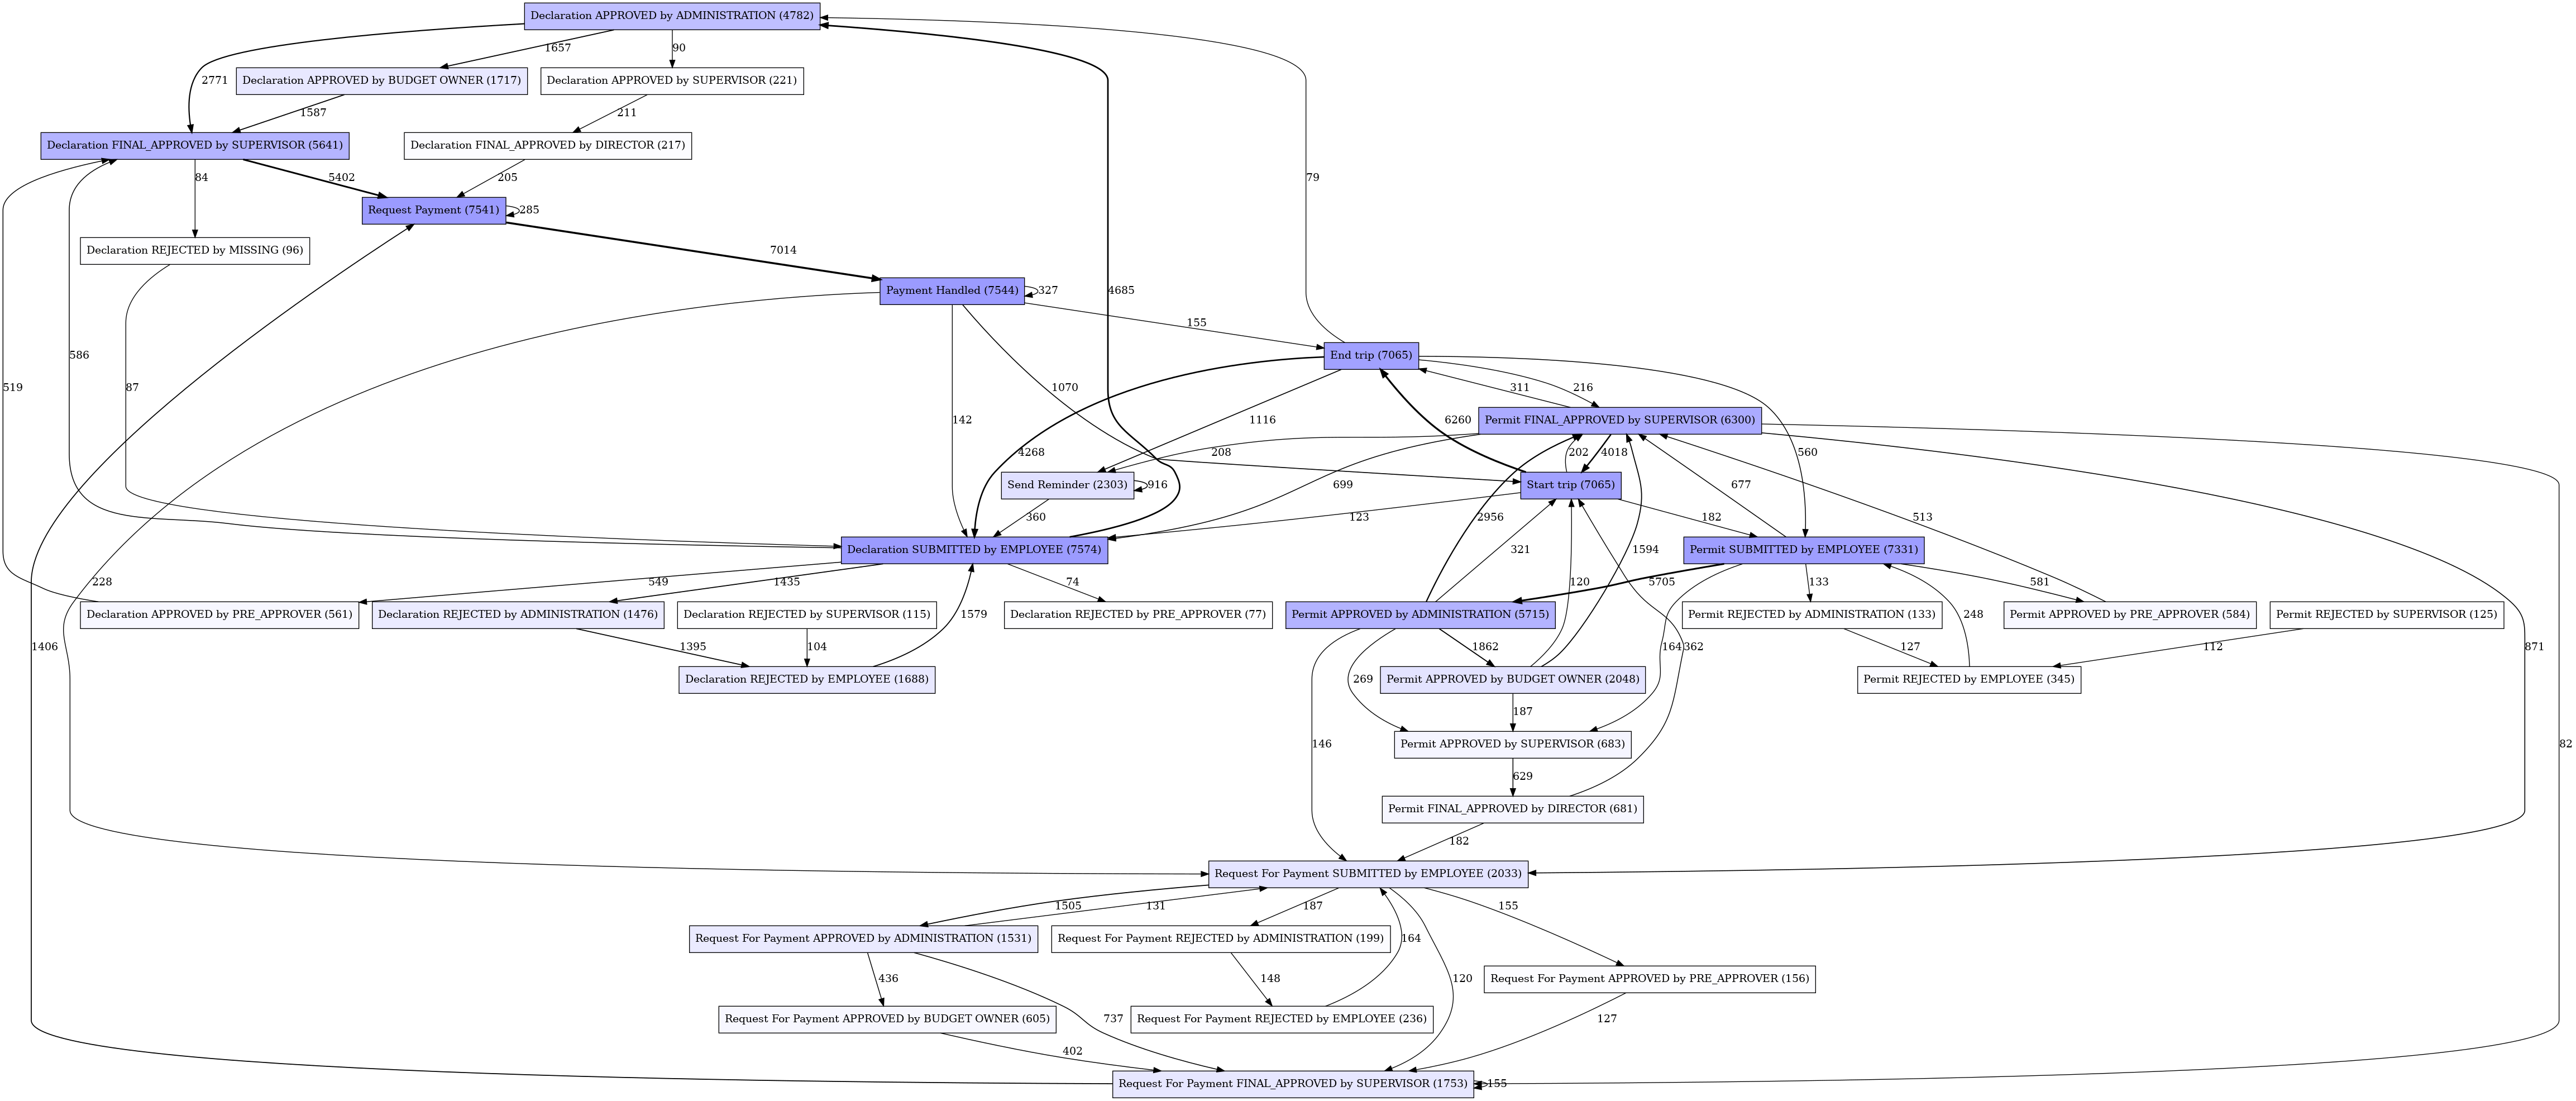

In [59]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(logs[TP])

from pm4py.visualization.dfg import visualizer as dfg_visualization
gviz = dfg_visualization.apply(dfg, log=logs[TP], variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)
dfg_visualization.save(gviz, '../visual/permits_dfg.png')

/home/argon/prog/BPI/pm/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecatedWarning: apply_tree is deprecated as of 1.3.0 and will be removed in 2.0.0. Use algorithm entrypoint instead
  # Remove the CWD from sys.path while we load stuff.


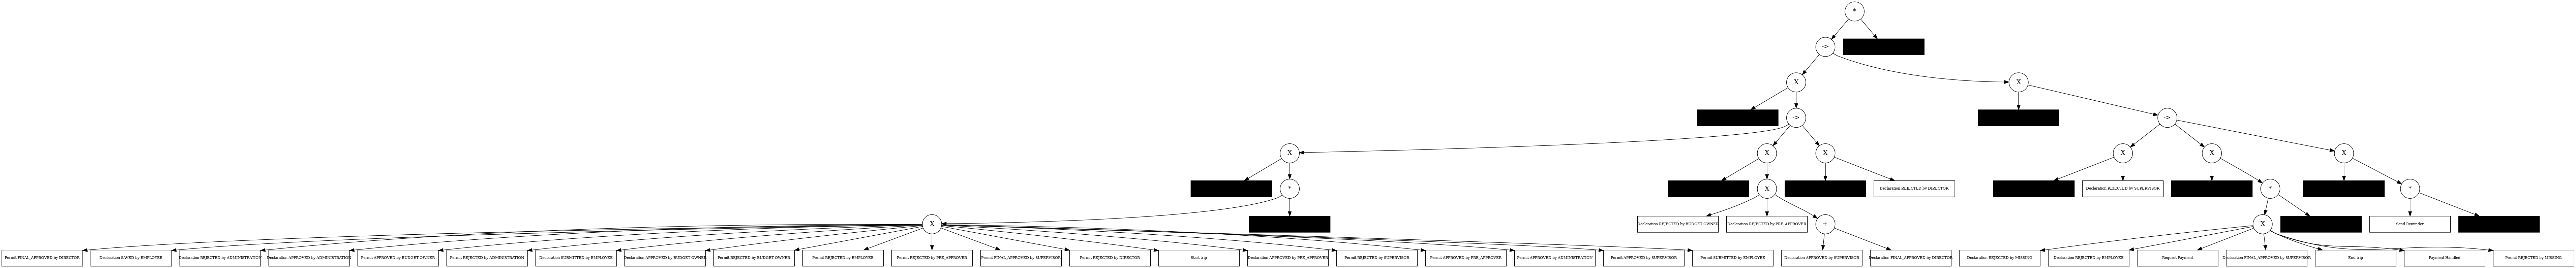

In [61]:
# from pm4py.visualization.petrinet import factory as pn_vis_factory
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer


# dom_vis = xes2dataframe(tuple(logs.keys())[0], configuration='default')
# net, im, fm = inductive_miner.apply(dom_vis)
# gviz = pn_vis_factory.apply(net, im, fm, variant="frequency")
# pn_vis_factory.view(gviz)
tree = inductive_miner.apply_tree(logs[ID])

gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

In [ ]:
from pm4py.objects.conversion.log import factory as conversion_factory
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.visualization.dfg import factory as dfg_vis_factory

log_d18 = conversion_factory.apply(dd_18)
dfg_d18 = dfg_factory.apply(log_d18)
gviz = dfg_vis_factory.apply(dfg_d18, log=log_d18, variant="frequency")
dfg_vis_factory.view(gviz)

In [16]:
%run display_inline.py
# DOESN'T display more than 10 values by default

In [24]:
#  DD, ID, PT, RP, TP
curr_df = all_dfs[DD]  # table's chosen
# following is only for domestic declarations yet

In [261]:
# %cat domestic_declarations_fields
# %%capture domestic_declarations_fields
domestic_declarations_fields.show()

UsageError: Line magic function `%%capture` not found.


In [238]:
#  DD, ID, PT, RP, TP
curr_df = all_dfs[ID]  # table's chosen
# following is only for domestic declarations yet

In [244]:
# %cat international_declarations_fields
# %%capture international_declarations_fields
international_declarations_fields.show()

international case


,id_cat,id,org_resource,concept_name,org_role,case_Permit_travel_permit_number,case_DeclarationNumber,case_Permit_TaskNumber,case_Permit_BudgetNumber,case_Permit_ProjectNumber,case_concept_name,case_Permit_OrganizationalEntity,case_travel_permit_number,case_id,case_Permit_ID,case_Permit_id,case_BudgetNumber,case_Permit_ActivityNumber
count,72151,72151,72151,72151,72151,72151,72151,72151,72151,72151,72151,72151,72151,72151,72151,72151,72151,72151
unique,7,56864,2,34,8,5596,6190,6,207,825,6449,27,6033,6449,6028,5608,719,145
top,st_step_class_0,423,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,EMPLOYEE,424,UNKNOWN,427,425,UNKNOWN,7022,65458,73563,7022,73562,423,146697,UNKNOWN
freq,46449,898,59347,8099,29338,3377,2096,44537,3730,27106,27,15585,170,27,170,3377,683,67304


,id_cat
st_step_class_0,46449
rv_travel_class_7,6449
rv_travel_class_6,6449
fd_declaration_class_18,6187
fd_declaration_class_17,6183
rv_travel_class_27,406
rv_travel_class_28,28
,case_Amount
count,72151.000000
mean,806.151668


In [264]:
#  DD, ID, PT, RP, TP
curr_df = all_dfs[TP]  # table's chosen
# following is only for domestic declarations yet

In [273]:
# %cat travel_permitions_fields
# %%capture travel_permitions_fields
travel_permitions_fields.show()

UsageError: Line magic function `%%capture` not found.


__category values: most important features__

In [214]:
#  DD, ID, PT, RP, TP
curr_df = all_dfs[DD]  # table's chosen
# following is only for domestic declarations yet
df_obj = curr_df.select_dtypes(include=['category']).copy()
# display(df_obj.describe())
cat = df_obj.concept_name
print('AMOUNT of ... :\t', cat.unique().shape, '\n', cat.unique())

AMOUNT of ... :	 (17,) 
 [Declaration SUBMITTED by EMPLOYEE, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled, Declaration APPROVED by PRE_APPROVER, ..., Declaration FOR_APPROVAL by SUPERVISOR, Declaration REJECTED by ADMINISTRATION, Declaration FOR_APPROVAL by PRE_APPROVER, Declaration REJECTED by BUDGET OWNER, Declaration FOR_APPROVAL by ADMINISTRATION]
Length: 17
Categories (17, object): [Declaration SUBMITTED by EMPLOYEE, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled, ..., Declaration REJECTED by ADMINISTRATION, Declaration FOR_APPROVAL by PRE_APPROVER, Declaration REJECTED by BUDGET OWNER, Declaration FOR_APPROVAL by ADMINISTRATION]


#### __for me, will use it for merge possibly__

In [25]:
# pd.get_dummies(curr_df, columns=['id'])
# curr_df.id[0]
# id_cat = pd.DataFrame(curr_df.id.apply(lambda x: f'{x.split()[0]}_class_{x.split("_")[-1]}'))\
#                                     .rename(columns={'id': 'id_cat'})
# curr_df.id = curr_df.id.apply(lambda x: atoi_like(x))
# id_cat
# id_map = pd.melt(pd.merge(curr_df, id_cat, on=curr_df.index, how='inner'),\
#                  id_vars=['id_cat'], value_vars=['id'], value_name='id').drop(['variable', 'id'], axis=1)
# id_map
# pd.merge(id_cat, curr_df, on=curr_df.index, how='right').drop('key_0', axis=1).shape  # always use on with index, otherwise you get dups

,id_cat
0,76455_class_76455
1,76455_class_76455
2,76459_class_76459
3,76460_class_76460
4,76461_class_76461
...,...
72146,13239_class_13239
72147,13241_class_13241
72148,13240_class_13240
72149,13226_class_13226


In [218]:
display_inline(pd.DataFrame(curr_df.case_DeclarationNumber.describe()),\
               pd.DataFrame(curr_df.case_concept_name.describe()))

,case_DeclarationNumber
count,56437
unique,10049
top,UNKNOWN
freq,1290
,case_concept_name
count,56437
unique,10500
top,113462
freq,24


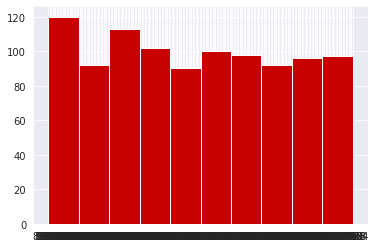

In [137]:
curr_df.case_DeclarationNumber[:1000].hist()

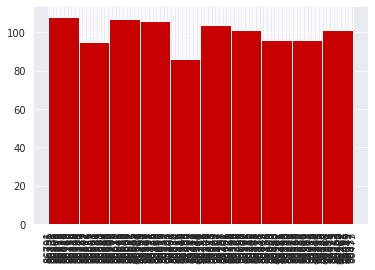

In [177]:
fig, ax = plt.subplots()
curr_df.case_concept_name[:1000].hist()
plt.setp(ax.get_xticklabels(), rotation=90);

In [29]:
# tmp = curr_df[:10]
tmp

,id_cat,id,org_resource,concept_name,time_timestamp,org_role,case_id,case_concept_name,case_BudgetNumber,case_DeclarationNumber,case_Amount
0,st_step_class_0,86794,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 08:49:50,EMPLOYEE,86791,86791,86566,86792,26
1,st_step_class_0,86793,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 10:27:48,SUPERVISOR,86791,86791,86566,86792,26
2,dd_declaration_class_19,86791,SYSTEM,Request Payment,2017-01-10 08:34:44,UNDEFINED,86791,86791,86566,86792,26
3,dd_declaration_class_20,86791,SYSTEM,Payment Handled,2017-01-12 16:31:22,UNDEFINED,86791,86791,86566,86792,26
4,st_step_class_0,86798,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:26:14,EMPLOYEE,86795,86795,86566,86796,182
5,st_step_class_0,86799,STAFF MEMBER,Declaration APPROVED by PRE_APPROVER,2017-02-22 09:29:21,PRE_APPROVER,86795,86795,86566,86796,182
6,st_step_class_0,86797,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-02-23 07:14:45,SUPERVISOR,86795,86795,86566,86796,182
7,dd_declaration_class_19,86795,SYSTEM,Request Payment,2017-03-06 13:07:25,UNDEFINED,86795,86795,86566,86796,182
8,dd_declaration_class_20,86795,SYSTEM,Payment Handled,2017-03-13 16:30:59,UNDEFINED,86795,86795,86566,86796,182
9,st_step_class_0,86804,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:13:33,EMPLOYEE,86800,86800,86566,86801,320


In [37]:
# tmp = curr_df.drop('id_cat', axis=1)
# pd.concat([tmp], keys=curr_df.id_cat)
# curr_df.groupby('id_cat').count()
test = pd.pivot_table(tmp, values=['case_Amount'],\
               index=['id_cat', 'id'],\
               columns='org_role',\
               aggfunc={'case_Amount': 'last'}, fill_value='-1')#.\
#                query('case_id < "90000" and case_id > "89000"')  # choice of aggfunc and other params isn't evident

#### remember seaborn hue 

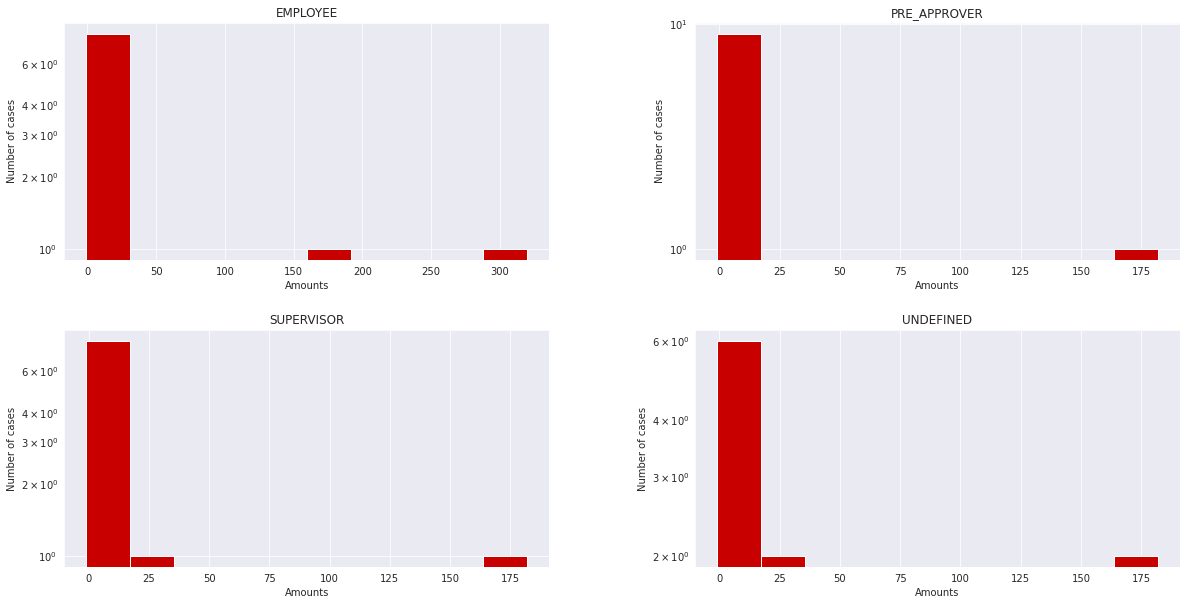

In [176]:
fig, axes = plt.subplots(len(test.case_Amount.columns)//2, 2, figsize=(20,10))
for cat, ax in zip(test.case_Amount, axes.flatten()):
    df = test.case_Amount[f'{cat}'].reset_index()
    df[f'{cat}'] = df[f'{cat}'].astype('int32')
    df.hist(ax=ax)
    ax.set_yscale('log')
    ax.set_xlabel('Amounts')
    ax.set_ylabel('Number of cases')
    ax.tick_params('both')
# ax.plot(curr_df.id[:100], (curr_df
#     axes[i,j].set_title(pays_arrangement[i][j])


***
<font color='#D60B0B' size=6><center>Plan</center></font>

<font color='#D60B0B' size=5><center>Goals, needs, expectations</center></font>
***
1. <font size=4>__Архитектура BPMT__</font>

_BPMT - Business Process Management + IT_

__*Все решения должны обеспечивать определенный функционал*__

__*Аналитика выполняется с использованием графических средств (блок-схем или диаграмм, которые легко анализировать)*__

__*У меня пока как то нет математики, взять бы какое то популярное решение из статей для восполнения*__

> __Процессы__
   * контроль хода реализации задач;
   * объединение задач в процессы и назначение в группы, обеспечение корректного перехода к одной к другой;
   * отслеживание, на каком этапе процесс, кто в данный момент его исполнитель, и какие изменения происходили до настоящего момента;
   * модель поведения отдельного сотрудника;
   * будущее состояние процесса (возможно ли?). 
   
> __Бизнес аналитика__
   * выделение измеряемых характеристик;
   * составление чистого датасета, на котором можно строить прозрачную аналитику и модели;
   * мониторинг ключевых показателей, инкам-ауткам, результаты, отклонение от средних, влияние на бизнес;
   * представление сущностей, общепринятые методы оценки, ссылки-сравнения.

> __Отчет__
   * постановка целей;
   * регламентирование процессов, разграничение процессов по ролям, характеристики;
   * анализ ошибок в данных, артефакты, хронология;
   * использование подходов, результатов известных работ;
   * человеческое описание смоделированных ситуаций;
   * ответы на вопросы;
   * может быть - предложения по оптимизации процессов.
   
2. <font size=4>__Физический продукт__</font>

__*Необходимо сделать отчет, который можно покрутить, пощупать, не только pdf.*__

__*В идеале запустить как презентацию со скрытой реализацией интерактивных слайдов*__

<font><center>__Здесь у меня есть некоторые идеи__</center></font>

***
<font color='#D60B0B' size=5><center>My wild dreams</center></font>
***

* На данный момент мой ноутбук напоминает data handling engile, данные специально для соревнования. То есть, это похоже на __бэкенд__.

* Всякие радости картинок можно быстро накрутить в __salesforce einstein__.
Как будет ясно, какие нужны, оформлю это python кодом.

* <font color='red'>__Process graphs__ от Сергея. Пока понятия не имею, как будет выглядеть. Пока идеи.</font>
    1. Привести процессы в disco к нужному виду -> Переписать csv -> Залить в einstein и уже тогда business analytics.
    2. Отдельно рассмотреть петли, потери, форс-мажор.
    
    
* __Bot analytics search engine__ для ответа на вопросы соревнования.

    1. Закодированные фразы для команд движка - __bag of words (phrases)__. Это будут __rules__.
    2. __Строка поиска__ с возможностью задать совершенно любой вопрос по данным.
    3. А вот с помощью __переводчика__ и cosine метрик перенаправлять этот вопрос на rules бота.
    4. __Исполнение команд бэкенда__ из сета, сформированного по вопросу. 

Наверное, так можно получить ответы на абстрактные запросы. Дефолтное поведение пока не придумал.
***
<font color='#D60B0B' size=3><center>Пример поведения помощника от IBM</center></font>
***
<img src='../IBMques.gif' style='width:800px'>

### section is in develop 

,0
count,641.000000
mean,404.939158
std,359.093804
min,0.000000
25%,160.000000
50%,322.000000
75%,534.000000
max,3292.000000
,case_Amount
count,641.000000


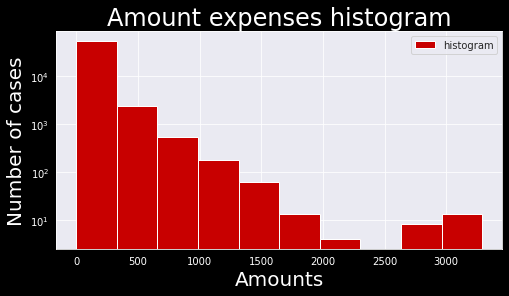

In [72]:
amount_cases = curr_df.case_Amount.value_counts()

display_inline(pd.DataFrame(amount_cases.index).describe(),  # case amount values 
               pd.DataFrame(amount_cases).describe(),  # counts with unique amount values (how much)
               pd.DataFrame(curr_df.case_BudgetNumber.value_counts()))

def plot_pipeline(plotter, figsize=(8, 4), title='Title', label='label', yscale='linear', xscale='linear', facecolor='k',\
                  xlabel='xlabel', ylabel='ylabel', title_size=24, axis_size=20, frameon=True):  # in develop
    """Custom decorator for plotting function; Has special limited set of parameters"""
    
    def wrapper(): # in develop
        plotter(ax=ax, label=label)
        ax = plt.figure(figsize=figsize, facecolor=facecolor, frameon=frameon).add_subplot()
        ax.set_title(title, color='w', size=title_size)
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
        ax.set_xlabel(xlabel, color='w', size=axis_size)
        ax.set_ylabel(ylabel, color='w', size=axis_size)
#         plotter(ax=ax, label=label)
        ax.legend()

    return wrapper

@plot_pipeline
def show(plotter):  # ahahaha
    return plotter

# show(curr_df.case_Amount.hist())
# plot_pipeline(curr_df.case_Amount.hist())

ax = plt.figure(figsize=(8, 4), facecolor='k').add_subplot()
ax.set_yscale('log')
ax.set_title(label='Amount expenses histogram', color='w', size=24)
ax.set_xlabel('Amounts', color='w', size=20)
ax.set_ylabel('Number of cases', color='w', size=20)
ax.tick_params('both', colors='w')
# ax.plot(curr_df.id[:100], (curr_df.case_Amount / np.max(curr_df.case_Amount))[:100])
curr_df.case_Amount.hist(ax=ax, label=['histogram']);
ax.legend();

In [28]:
import matplotlib as mpl
from matplotlib.transforms import Bbox

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [30]:
curr_df.case_Amount.value_counts()

0      1265
17      963
31      924
20      893
26      890
       ... 
335       4
495       4
633       4
420       4
598       4
Name: case_Amount, Length: 641, dtype: int64

,case_Amount
0,26
1,26
2,26
3,26
4,182
5,182
6,182
7,182
8,182
9,320


<Figure size 432x288 with 0 Axes>

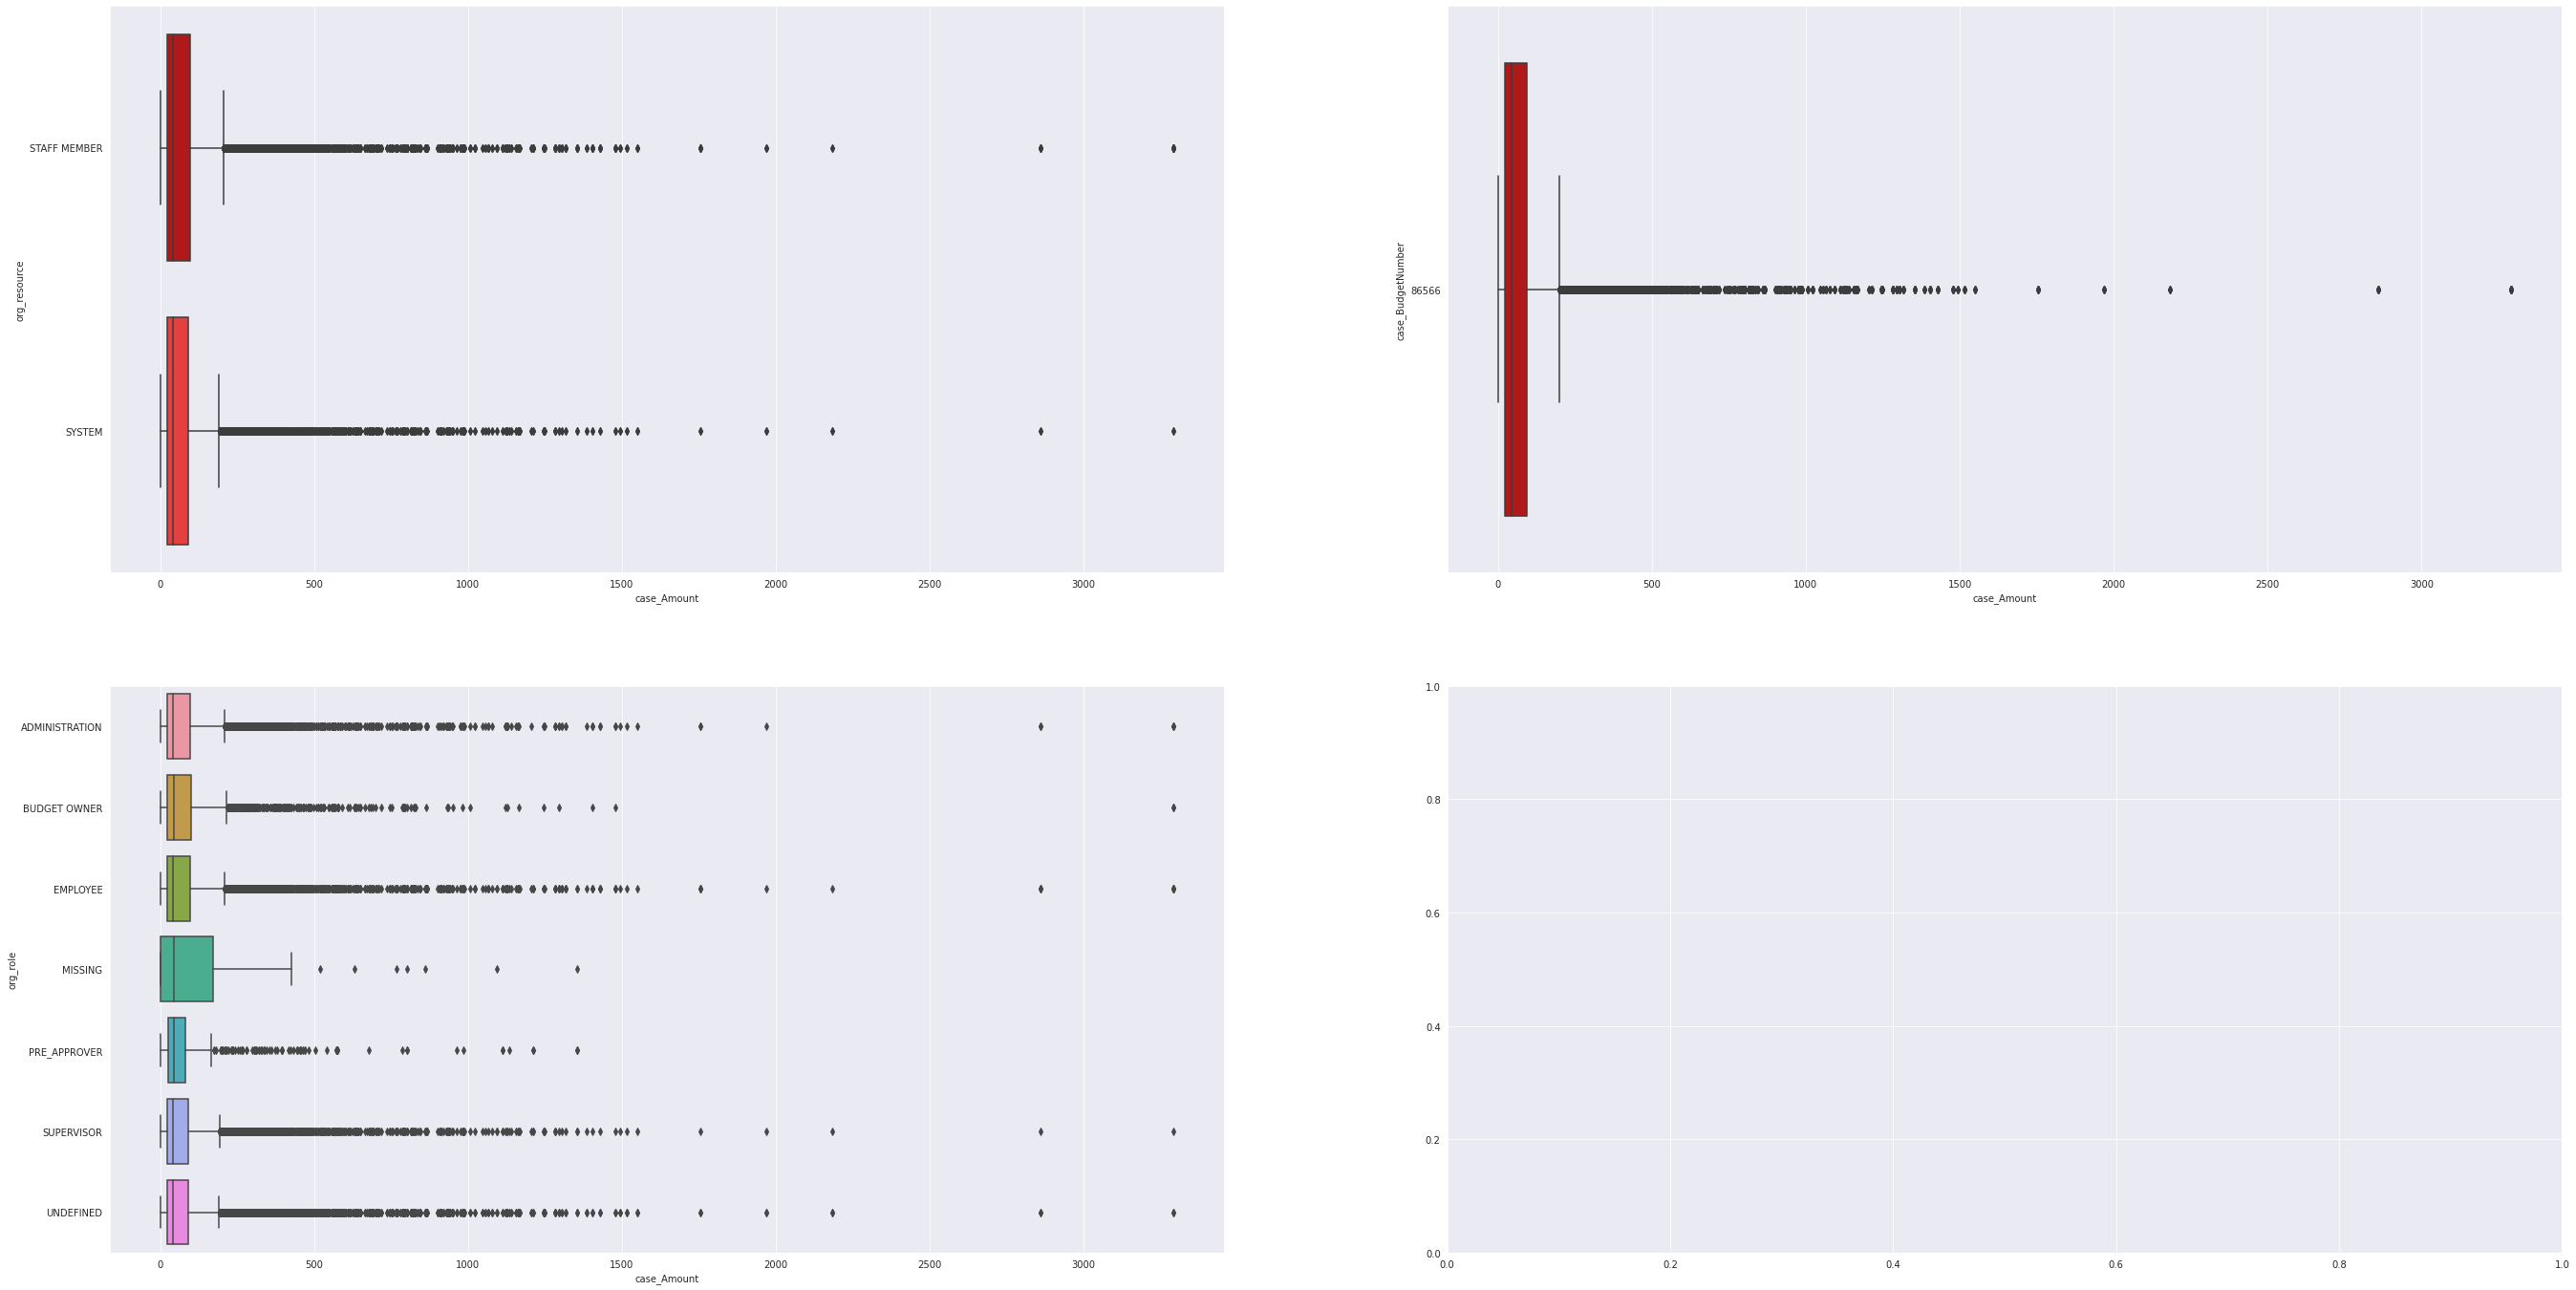

In [29]:
%run display_inline.py

gb = curr_df.groupby('case_BudgetNumber', as_index=False, sort=True)
display_inline(gb.cummax()[['case_Amount']],\
               gb.cumsum()[['case_Amount']], gb.cumprod()[['case_Amount']], start=0, stop=20)

fields = ['case_Amount', 'case_BudgetNumber', 'org_resource', 'org_role']
fig, axes = plt.subplots(2, 2, figsize=(46, 24));
sns.boxplot(x='case_Amount', y='org_resource', data=curr_df, ax=axes[0, 0]);
sns.boxplot(x='case_Amount', y='case_BudgetNumber', data=curr_df, ax=axes[0, 1]);
sns.boxplot(x='case_Amount', y='org_role', data=curr_df, ax=axes[1, 0]);
# fig.savefig('boxplot3.png', bbox_inches=axes[1,0].get_window_extent().transformed\
#             (fig.dpi_scale_trans.inverted()));  #  saves only inner

### section is RAW

In [ ]:
fig, ax = plt.subplots(5, 2)

for i in range(10):
    for col in curr_df.columns:
        gb = curr_df.groupby(f'{col}', as_index=False, sort=True)
        

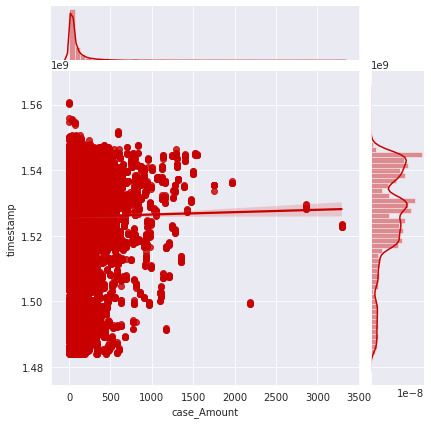

In [30]:


curr_df['timestamp'] = curr_df.time_timestamp.apply(lambda x: x.timestamp())
sns.jointplot(x='case_Amount', y='timestamp',  kind="reg", data=curr_df);
# sns.boxplot(y='case_RequestedBudget', data=curr_df);


# fig = plt.figure()
# 
# ax1 = fig.add_subplot(1,2,1)
# ax1.plot(.cumsum(), 'k-')

# same as before
# ax2 = fig.add_subplot(1,2,2)           # this indicates color and line style
# ax2.plot(np.random.randn(50).cumsum(), 'r-')

!NOTE: be careful with 'id' float conv. FIXME

In [15]:
df.corr()  # numeric corr

,case:TotalDeclared,case:Overspent,case:RequestedBudget,case:OverspentAmount,case:Cost Type_1,case:Cost Type_0,case:Cost Type_3,case:Cost Type_2,case:Cost Type_7,case:Cost Type_6,case:Cost Type_9,case:Cost Type_8,case:Cost Type_5,case:Cost Type_4,case:Cost Type_13,case:Cost Type_14,case:Cost Type_10,case:Cost Type_11,case:Cost Type_12
case:TotalDeclared,1.000000,0.037617,0.044847,0.998278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Overspent,0.037617,1.000000,0.010762,0.042257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:RequestedBudget,0.044847,0.010762,1.000000,-0.005014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:OverspentAmount,0.998278,0.042257,-0.005014,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
for i in range(12):   # what was THAT?? TP?
    print(df[f'case:DeclarationNumber_{i+1}'].value_counts())
df.shape

UNKNOWN                     1429
declaration number 73567      90
declaration number 53349      75
declaration number 32582      61
declaration number 45623      53
                            ... 
declaration number 80690      11
declaration number 82739      11
declaration number 11192      11
declaration number 83935      10
declaration number 76003       9
Name: case:DeclarationNumber_1, Length: 912, dtype: int64
UNKNOWN                     740
declaration number 73569     90
declaration number 53351     75
declaration number 32584     61
declaration number 45625     53
                           ... 
declaration number 78111     16
declaration number 85569     16
declaration number 16520     16
declaration number 77288     15
declaration number 83429     14
Name: case:DeclarationNumber_2, Length: 275, dtype: int64
UNKNOWN                     560
declaration number 73571     90
declaration number 53353     75
declaration number 32586     61
declaration number 45627     53
         

(86581, 173)

In [45]:
hypo_data = df_hypo.groupby(by=df_hypo.index).mean().fillna(0).values
np.unique(hypo_data)  # 150 columns of nothing

array([0.])

In [174]:
df_obj = df.select_dtypes(include=['category']).copy()  # to show do df cast with 'default'
df_obj.describe()

ValueError: Cannot describe a DataFrame without columns

In [151]:
cat = df_obj.org_resource.astype('category')
print('AMOUNT:\t', cat.unique().shape, '\n', cat.unique())

AMOUNT:	 (2,) 
 [STAFF MEMBER, SYSTEM]
Categories (2, object): [STAFF MEMBER, SYSTEM]


In [162]:
print(mem_usage(cat), mem_usage(df_obj.org_resource))  # not bad

0.07 MB 4.67 MB


In [173]:
df_obj = df.select_dtypes(include=['object']).copy()
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.8:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]
        
        
print(mem_usage(df_obj))
print(mem_usage(converted_obj))

0.00 MB
0.00 MB


In [161]:
df[converted_obj.columns] = converted_obj
mem_usage(df)

'14.02 MB'

In [148]:
cat = df_obj.org_role.astype('category')
print('AMOUNT:\t', cat.unique().shape, '\n', cat.unique())

AMOUNT:	 (8,) 
 [EMPLOYEE, SUPERVISOR, UNDEFINED, DIRECTOR, PRE_APPROVER, ADMINISTRATION, MISSING, BUDGET OWNER]
Categories (8, object): [EMPLOYEE, SUPERVISOR, UNDEFINED, DIRECTOR, PRE_APPROVER, ADMINISTRATION, MISSING, BUDGET OWNER]


In [144]:
cat = df_obj.concept_name.astype('category');
print('AMOUNT:\t', cat.unique().shape, '\n', cat.unique())

AMOUNT:	 (34,) 
 [Start trip, End trip, Permit SUBMITTED by EMPLOYEE, Permit FINAL_APPROVED by SUPERVISOR, Declaration SUBMITTED by EMPLOYEE, ..., Permit APPROVED by BUDGET OWNER, Permit REJECTED by ADMINISTRATION, Declaration REJECTED by BUDGET OWNER, Permit REJECTED by BUDGET OWNER, Permit REJECTED by DIRECTOR]
Length: 34
Categories (34, object): [Start trip, End trip, Permit SUBMITTED by EMPLOYEE, Permit FINAL_APPROVED by SUPERVISOR, ..., Permit REJECTED by ADMINISTRATION, Declaration REJECTED by BUDGET OWNER, Permit REJECTED by BUDGET OWNER, Permit REJECTED by DIRECTOR]


[how to](https://www.dataquest.io/blog/pandas-big-data/) significantly reduce mem usage

BTW remember to fill UNKNOWN e.t.c

In [78]:
# case_id is not the same as DeclarationNumber
df.groupby('case_id', as_index=False)['case_DeclarationNumber'].apply(lambda x: x)

0      12788    declaration number 100001
       12789    declaration number 100001
       12790    declaration number 100001
       12791    declaration number 100001
       12792    declaration number 100001
                          ...            
10499  12756     declaration number 99996
       12757     declaration number 99996
       12758     declaration number 99996
       12759     declaration number 99996
       12760     declaration number 99996
Name: case_DeclarationNumber, Length: 56437, dtype: object

In [136]:
df.head(3)

,id,org_resource,concept_name,time_timestamp,org_role,case_id,case_concept_name,case_BudgetNumber,case_DeclarationNumber,case_Amount
0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+01:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+01:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 09:34:44+01:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205


In [128]:
# in development
def df_through(column):
    return df[column].apply(lambda x: atoi_like(x))

In [157]:
for col in df.columns:
    df[col] = df[col].apply(lambda x: atoi_like(x))
# what did _digit in id mean? FIXME
df.head(3)а

,id,org_resource,concept_name,time_timestamp,org_role,case_id,case_concept_name,case_BudgetNumber,case_DeclarationNumber,case_Amount
0,86794,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+01:00,EMPLOYEE,86791,86791,86566,86792,26.851205
1,86793,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+01:00,SUPERVISOR,86791,86791,86566,86792,26.851205
2,86791,SYSTEM,Request Payment,2017-01-10 09:34:44+01:00,UNDEFINED,86791,86791,86566,86792,26.851205


In [234]:
pd.pivot_table(df, values='concept_name',\
               index='case_id',\
               columns='org_role', fill_value='⚠️',\
               aggfunc=',->'.join)

org_role,ADMINISTRATION,BUDGET OWNER,EMPLOYEE,MISSING,PRE_APPROVER,SUPERVISOR,UNDEFINED
case_id,,,,,,,
100000,Declaration APPROVED by ADMINISTRATION,⚠️,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
100005,Declaration APPROVED by ADMINISTRATION,⚠️,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
100010,Declaration APPROVED by ADMINISTRATION,⚠️,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
100015,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
100021,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
...,...,...,...,...,...,...,...
99973,Declaration APPROVED by ADMINISTRATION,⚠️,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
99978,Declaration APPROVED by ADMINISTRATION,⚠️,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
99983,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"


In [225]:
pd.pivot_table(df, values=['case_Amount', 'concept_name'],\
               index=['case_DeclarationNumber', 'case_id'],\
               columns='org_role', fill_value='⚠️').\
               query('case_id < "90000" and case_id > "89000"')

case_Amount                           \
org_role                       ADMINISTRATION BUDGET OWNER    EMPLOYEE   
case_DeclarationNumber case_id                                           
89005                  89004               ⚠️           ⚠️   71.129552   
89010                  89009               ⚠️           ⚠️  134.457797   
89014                  89013               ⚠️           ⚠️   46.058080   
89018                  89017               ⚠️           ⚠️   49.179209   
89022                  89021               ⚠️           ⚠️   31.469399   
...                                       ...          ...         ...   
UNKNOWN                89820               ⚠️           ⚠️    0.000000   
                       89830               ⚠️           ⚠️    0.000000   
                       89848               ⚠️           ⚠️    0.000000   
                       89887               ⚠️           ⚠️    0.000000   
                       89973               ⚠️           ⚠️    0.000000   

                                                                          
org_role                       MISSING PRE_APPROVER SUPERVISOR UNDEFINED  
case_DeclarationNumber case_id                                            
89005                  89004        ⚠️      71.1296    71.1296   71.1296  
89010                  89009        ⚠️           ⚠️    134.458   134.458  
89014                  89013        ⚠️           ⚠️    46.0581   46.0581  
89018                  89017        ⚠️           ⚠️    49.1792   49.1792  
89022                  89021        ⚠️           ⚠️    31.4694   31.4694  
...                                ...          ...        ...       ...  
UNKNOWN                89820        ⚠️           ⚠️         ⚠️        ⚠️  
                       89830        ⚠️            0          0        ⚠️  
                       89848        ⚠️           ⚠️         ⚠️        ⚠️  
                       89887         0           ⚠️          0        ⚠️  
                       89973        ⚠️            0          0        ⚠️  

[222 rows x 7 columns]

In [209]:
# df.pivot(index='case_id', columns='org_role', values='case_Amount')
# Index contains duplicate entries, cannot reshape
df.pivot_table(index='case_id', columns='org_role', values='case_Amount')..describe()
# in MISSING have 87 not na values with 24 null values
# in UNDEFINED only 453 are na

50.928409     32
52.499349     22
6.360310      21
43.977730     19
31.892582     16
              ..
201.880202     1
10.699429      1
283.618695     1
9.145726       1
34.961227      1
Name: UNDEFINED, Length: 8320, dtype: int64

In [221]:
pd.pivot_table(df, values=['case_Amount', 'concept_name'],\
               index=['case_DeclarationNumber', 'case_id', 'case_BudgetNumber'],\
               columns='org_role',
               aggfunc='first', fill_value='⚠️').\
               query('case_id < "90000" and case_id > "89000"')  # choice of aggfunc and other params isn't evident

case_Amount               \
org_role                                         ADMINISTRATION BUDGET OWNER   
case_DeclarationNumber case_id case_BudgetNumber                               
89005                  89004   86566                         ⚠️           ⚠️   
89010                  89009   86566                         ⚠️           ⚠️   
89014                  89013   86566                         ⚠️           ⚠️   
89018                  89017   86566                         ⚠️           ⚠️   
89022                  89021   86566                         ⚠️           ⚠️   
...                                                         ...          ...   
UNKNOWN                89820   86566                         ⚠️           ⚠️   
                       89830   86566                         ⚠️           ⚠️   
                       89848   86566                         ⚠️           ⚠️   
                       89887   86566                         ⚠️           ⚠️   
                       89973   86566                         ⚠️           ⚠️   

                                                                      \
org_role                                            EMPLOYEE MISSING   
case_DeclarationNumber case_id case_BudgetNumber                       
89005                  89004   86566               71.129552      ⚠️   
89010                  89009   86566              134.457797      ⚠️   
89014                  89013   86566               46.058080      ⚠️   
89018                  89017   86566               49.179209      ⚠️   
89022                  89021   86566               31.469399      ⚠️   
...                                                      ...     ...   
UNKNOWN                89820   86566                0.000000      ⚠️   
                       89830   86566                0.000000      ⚠️   
                       89848   86566                0.000000      ⚠️   
                       89887   86566                0.000000       0   
                       89973   86566                0.000000      ⚠️   

                                                                          \
org_role                                         PRE_APPROVER SUPERVISOR   
case_DeclarationNumber case_id case_BudgetNumber                           
89005                  89004   86566                  71.1296    71.1296   
89010                  89009   86566                       ⚠️    134.458   
89014                  89013   86566                       ⚠️    46.0581   
89018                  89017   86566                       ⚠️    49.1792   
89022                  89021   86566                       ⚠️    31.4694   
...                                                       ...        ...   
UNKNOWN                89820   86566                       ⚠️         ⚠️   
                       89830   86566                        0          0   
                       89848   86566                       ⚠️         ⚠️   
                       89887   86566                       ⚠️          0   
                       89973   86566                        0          0   

                                                             concept_name  \
org_role                                         UNDEFINED ADMINISTRATION   
case_DeclarationNumber case_id case_BudgetNumber                            
89005                  89004   86566               71.1296             ⚠️   
89010                  89009   86566               134.458             ⚠️   
89014                  89013   86566               46.0581             ⚠️   
89018                  89017   86566               49.1792             ⚠️   
89022                  89021   86566               31.4694             ⚠️   
...                                                    ...            ...   
UNKNOWN                89820   86566                    ⚠️             ⚠️   
                       89830   86566                    ⚠️             ⚠️   
          

In [224]:
pd.pivot_table(df, values=['case_Amount', 'concept_name'],\
               index=['case_DeclarationNumber', 'case_id', 'case_BudgetNumber'],\
               columns='org_role',
               aggfunc={'case_Amount': 'last', 'concept_name': ',\n'.join}, fill_value='⚠️').\
               query('case_id < "90000" and case_id > "89000"')  # choice of aggfunc and other params isn't evident

case_Amount               \
org_role                                         ADMINISTRATION BUDGET OWNER   
case_DeclarationNumber case_id case_BudgetNumber                               
89005                  89004   86566                         ⚠️           ⚠️   
89010                  89009   86566                         ⚠️           ⚠️   
89014                  89013   86566                         ⚠️           ⚠️   
89018                  89017   86566                         ⚠️           ⚠️   
89022                  89021   86566                         ⚠️           ⚠️   
...                                                         ...          ...   
UNKNOWN                89820   86566                         ⚠️           ⚠️   
                       89830   86566                         ⚠️           ⚠️   
                       89848   86566                         ⚠️           ⚠️   
                       89887   86566                         ⚠️           ⚠️   
                       89973   86566                         ⚠️           ⚠️   

                                                                      \
org_role                                            EMPLOYEE MISSING   
case_DeclarationNumber case_id case_BudgetNumber                       
89005                  89004   86566               71.129552      ⚠️   
89010                  89009   86566              134.457797      ⚠️   
89014                  89013   86566               46.058080      ⚠️   
89018                  89017   86566               49.179209      ⚠️   
89022                  89021   86566               31.469399      ⚠️   
...                                                      ...     ...   
UNKNOWN                89820   86566                0.000000      ⚠️   
                       89830   86566                0.000000      ⚠️   
                       89848   86566                0.000000      ⚠️   
                       89887   86566                0.000000       0   
                       89973   86566                0.000000      ⚠️   

                                                                          \
org_role                                         PRE_APPROVER SUPERVISOR   
case_DeclarationNumber case_id case_BudgetNumber                           
89005                  89004   86566                  71.1296    71.1296   
89010                  89009   86566                       ⚠️    134.458   
89014                  89013   86566                       ⚠️    46.0581   
89018                  89017   86566                       ⚠️    49.1792   
89022                  89021   86566                       ⚠️    31.4694   
...                                                       ...        ...   
UNKNOWN                89820   86566                       ⚠️         ⚠️   
                       89830   86566                        0          0   
                       89848   86566                       ⚠️         ⚠️   
                       89887   86566                       ⚠️          0   
                       89973   86566                        0          0   

                                                             concept_name  \
org_role                                         UNDEFINED ADMINISTRATION   
case_DeclarationNumber case_id case_BudgetNumber                            
89005                  89004   86566               71.1296             ⚠️   
89010                  89009   86566               134.458             ⚠️   
89014                  89013   86566               46.0581             ⚠️   
89018                  89017   86566               49.1792             ⚠️   
89022                  89021   86566               31.4694             ⚠️   
...                                                    ...            ...   
UNKNOWN                89820   86566                    ⚠️             ⚠️   
                       89830   86566                    ⚠️             ⚠️   
          

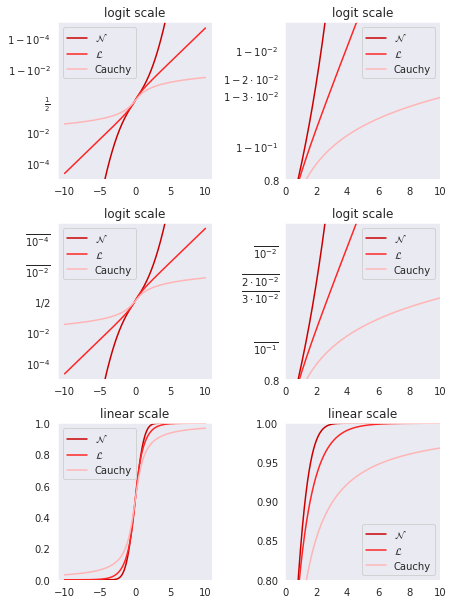

In [241]:
import math

import numpy as np
import matplotlib.pyplot as plt

xmax = 10
x = np.linspace(-xmax, xmax, 10000)
cdf_norm = [math.erf(w / np.sqrt(2)) / 2 + 1 / 2 for w in x]
cdf_laplacian = np.where(x < 0, 1 / 2 * np.exp(x), 1 - 1 / 2 * np.exp(-x))
cdf_cauchy = np.arctan(x) / np.pi + 1 / 2

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(6.4, 8.5))

# Common part, for the example, we will do the same plots on all graphs
for i in range(3):
    for j in range(2):
        axs[i, j].plot(x, cdf_norm, label=r"$\mathcal{N}$")
        axs[i, j].plot(x, cdf_laplacian, label=r"$\mathcal{L}$")
        axs[i, j].plot(x, cdf_cauchy, label="Cauchy")
        axs[i, j].legend()
        axs[i, j].grid()

# First line, logitscale, with standard notation
axs[0, 0].set(title="logit scale")
axs[0, 0].set_yscale("logit")
axs[0, 0].set_ylim(1e-5, 1 - 1e-5)

axs[0, 1].set(title="logit scale")
axs[0, 1].set_yscale("logit")
axs[0, 1].set_xlim(0, xmax)
axs[0, 1].set_ylim(0.8, 1 - 5e-3)

# Second line, logitscale, with survival notation (with `use_overline`), and
# other format display 1/2
axs[1, 0].set(title="logit scale")
axs[1, 0].set_yscale("logit", one_half="1/2", use_overline=True)
axs[1, 0].set_ylim(1e-5, 1 - 1e-5)

axs[1, 1].set(title="logit scale")
axs[1, 1].set_yscale("logit", one_half="1/2", use_overline=True)
axs[1, 1].set_xlim(0, xmax)
axs[1, 1].set_ylim(0.8, 1 - 5e-3)

# Third line, linear scale
axs[2, 0].set(title="linear scale")
axs[2, 0].set_ylim(0, 1)

axs[2, 1].set(title="linear scale")
axs[2, 1].set_xlim(0, xmax)
axs[2, 1].set_ylim(0.8, 1)

fig.tight_layout()
plt.show()

[__SNS Examples__](https://seaborn.pydata.org/examples/)

[__PLT.AXES__](https://matplotlib.org/api/axes_api.html)

[__PANDAS visualisation__](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

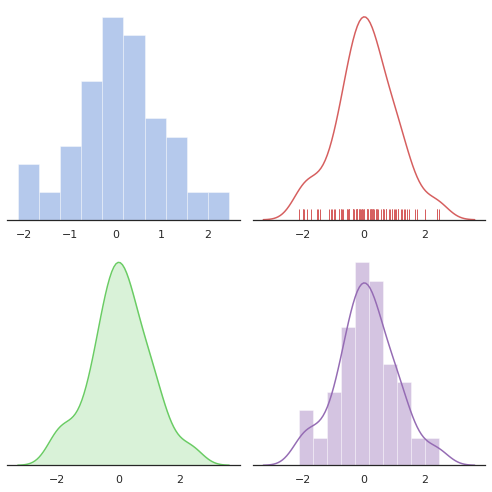

In [305]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.despine(left=True)

# Generate a random univariate dataset
d = rs.normal(size=100)

# Plot a simple histogram with binsize determined automatically
sns.distplot(d, kde=False, color="b", ax=axes[0, 0])

# Plot a kernel density estimate and rug plot
sns.distplot(d, hist=False, rug=True, color="r", ax=axes[0, 1])

# Plot a filled kernel density estimate
sns.distplot(d, hist=False, color="g", kde_kws={"shade": True}, ax=axes[1, 0])

# Plot a histogram and kernel density estimate
sns.distplot(d, color="m", ax=axes[1, 1])

plt.setp(axes, yticks=[])
plt.tight_layout()
